In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'

# Week 04, ASTR 596: Fundamentals of Data Science


## A Gentle introduction to Optimization

### Gautham Narayan 
##### <gsn@illinois.edu>



## Recap: Statistical Modeling "Wisdom"

Four Questions for a Bayesian:

1. What is the model?

2. What is the likelihood? Derive $L(\theta)$ from your sampling distribution $P(D|\theta)$

3. What are your priors $P(\theta)$?

4. How do you optimize/sample this objective function to model the data?

We've talked a lot about Q1 and Q2, less about Q3, and for Q4 we've been working through different methods: grid-search, gradient descent (i.e. scipy's fmin/optimize) 

We'll return to Q3, but to make progress, we need to deal with Q4 first because we're limiting the sorts of problems we can deal with

So far, we've restricted ourselves to inferences with:
* exact solutions - rare!
* linear-izable functions - because these are convex, and minimum is the global minimum!
* low-dimensional parameter spaces - limiting!

We can think of more complicated scenarios:

![Posteriors](./posteriors.png)

![CMD](cmd_all.png)

![Planet Posterior](Planet_posterior.png)

# Newton's Method (sometimes Newton-Raphson)

Goal: Want to find $x_c$, such that $f(x = x_c) = 0$ 

1. Make an initial guess that is half-way reasonable 

2. Iterate $ x_{n+1} = x_n - f(x_n)/f^\prime(x_n) $


![Newton-Raphson](NewtonRaphson.png)


Many function minimization algorithms are based on the fundamental idea of **gradient descent.** 

If a function f is differentiable, then at every point, the opposite of its gradient points to the direction of the greatest decrease rate of the function. 

By following this direction, we can expect to find a local minimum.


![Newton-Raphson](NewtonRaphson.png)


If you can compute an analytical expression of the gradient, you should provide it to the minimization routine. Otherwise, the algorithm will compute an approximation of the gradient that may not be reliable.

Newton's method can also be used in this context of function minimization. 

The idea is to find a root of the (derivative of the Likelihood with Newton's method (i.e. $f = L^\prime), thereby making use of the second derivative . 

In other words, we approximate the likelihood $L$ with a quadratic function instead of a linear function. 

In multiple dimensions, this is done by computing the Hessian (second derivatives) of $L$. 

By performing this operation iteratively, we can expect the algorithm to converge towards a local minimum.

This is what scipy.optimize is doing by default (actually now they've switched to BFGS) which is a Quasi-Newton method but not all that different.

# In class exercise:

Let's create a complicated e.g. of a likelihood in 2 dimensions.
You get to use scipy's optimize Nelder-Mead to figure out the minimum of this function.

Text(0.5, 0, 'eggholder(x, y)')

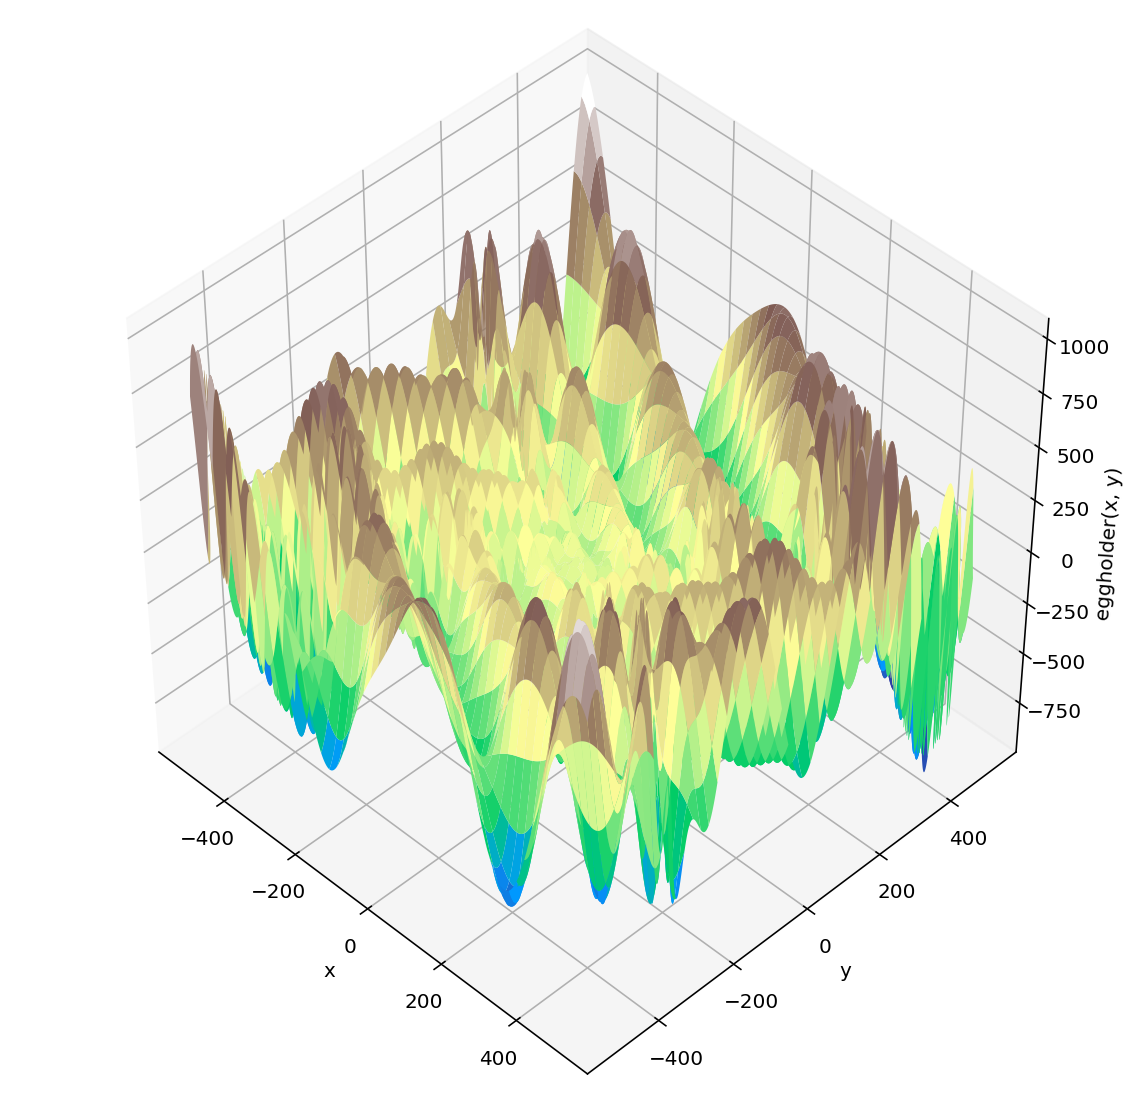

In [2]:
# RUN THIS
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize


def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))\
            -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

bounds = [(-512, 512), (-512, 512)]

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('eggholder(x, y)')


In [3]:
# use optimize.minimize to try to find the minimum
# try it 10 times with different starting guesses
# print out the minimum value, and the x, y location of the minimum
# since you already have the true function, get the minimum value 
# and the location of the minimum of your x, y grid

import scipy.stats as st
negLogLike = eggholder(xy)
print(negLogLike.min())

-959.579671903256


In [4]:
for i in range(10):
    guess = st.uniform.rvs(loc=-512, scale=1024, size=2)
    res = optimize.minimize(eggholder, guess)
    print(res.x, res.fun)
    
# notice how the minimum value is all over the place based on your starting guess.

[-323.18132829  531.6141726 ] -896.2937070839388
[ 399.55881407 -367.69104609] -716.6715003418209
[-323.18132354  531.61418075] -896.2937070838994
[ 18.10369011 365.96547569] -425.30150588260193
[864.71145479 617.54075339] -1523.3569929830462
[ 202.89664608 -269.38042694] -421.1557143749534
[-294.668251   -462.01968895] -704.8065959157711
[-242.97923149  274.38030319] -559.7868565504939
[-333.44694402  181.41571087] -558.520732097304
[ 399.55877527 -367.69106177] -716.671500341832


# Global Optimizers (use if you have a complex problem but low dimensionality)


Generally, these use a two step approach - something to take large steps to avoid local minima + another step to find the minima near the best of the big steps.

# Simulated annealing

Mimics the physical process of heating a material and then slowly lowering the temperature to decrease defects, thus minimizing the system energy.

At each iteration of the simulated annealing algorithm, a new point is randomly generated. 

The distance of the new point from the current point, or the extent of the search, is based on a probability distribution 

## $$ P = \exp(-\Delta L/kT) $$



The algorithm accepts all new points that lower the objective, but also, with a certain probability, points that raise the objective. 

By accepting points that raise the objective, the algorithm avoids being trapped in local minima, and is able to explore globally for more possible solutions.

![Simulated Annealing](sim_annealing_flow.png)


An annealing schedule is selected to systematically decrease the temperature as the algorithm proceeds. 

As the temperature decreases, the algorithm reduces the extent of its search to converge to a minimum.

Basin-hopping algorithm is a stochastic algorithm that seeks a global minimum by combining random perturbation of the positions and local minimization.

`scipy.optimize.basinhopping`

![Basin Hopping](basin_hopping.jpg)

Simplicial homology global optimization (SHGO) is another good option, particularly since it also returns all other local and global minimum in addition to the global minimum. 

It's using "novel, rigorously proven" methods that detect the homological properties of the objective function surface). 

![SHGO](shgo.svg)

## Use Basin-hopping, simulated annealing and SHGO to solve the eggholder problem

In [5]:
class MyBounds(object):
    def __init__(self, xmax=[512, 512], xmin=[-512,-512] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin

bounds = MyBounds()
res1 = optimize.basinhopping(eggholder, [st.uniform.rvs(loc=-512, scale=1024, size=2)],\
                             niter=10000, T=1, accept_test=bounds, seed=42)
print('Basin Hopping')
print(res1)

/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/gnarayan/miniconda3/envs/fds

Basin Hopping
                        fun: -816.3569902789512
 lowest_optimization_result:       fun: -816.3569902789512
 hess_inv: array([[2.02785661, 0.08426138],
       [0.08426138, 6.09092564]])
      jac: array([-7.62939453e-06, -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 148
      nit: 20
     njev: 37
   status: 0
  success: True
        x: array([203.33408112, 570.59594027])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 689
                       nfev: 278223
                        nit: 10000
                       njev: 68427
                          x: array([203.33408112, 570.59594027])


In [6]:
print('-------------')
res2 = optimize.shgo(eggholder, bounds=[(-512, 512), (-512, 512)], n=30, sampling_method='sobol')
print('SHGO')
print(res2)

-------------
SHGO
     fun: -959.6406627208496
    funl: array([-959.64066272, -718.16745962, -704.80659592, -565.99778097,
       -559.78685655, -557.36868733, -507.87385942, -493.9605115 ,
       -426.48799655, -421.15571437, -419.31194957, -410.98477763,
       -202.53912972])
 message: 'Optimization terminated successfully.'
    nfev: 717
     nit: 2
   nlfev: 657
   nlhev: 0
   nljev: 137
 success: True
       x: array([512.        , 404.23180614])
      xl: array([[ 512.        ,  404.23180614],
       [ 283.0759062 , -487.12565635],
       [-294.66820039, -462.01964031],
       [-105.87688911,  423.15323845],
       [-242.97926   ,  274.38030925],
       [-506.25823477,    6.3131022 ],
       [-408.71980731, -156.10116949],
       [ 150.23207937,  301.31376595],
       [  91.00920901, -391.283763  ],
       [ 202.89662724, -269.38043241],
       [ 361.66623976, -106.96493868],
       [-219.40612786, -244.06020508],
       [ 151.59603137, -100.61082677]])


# Curse of Dimensionality

![Curse of Dimensionality](ndim.png)

You did something very different on how your homework assignment

- you simulated the experiment over and over, drawing random samples from a distribution of your parameter

- you picked those draws where the simulated experiment matched your real data (Alice has won 5 games by game 8, Bob wins at the end) 
    - i.e. you rejected the others

- you determined the frequency of the outcome you are interested in happening.

A history of the Monte Carlo method and the Manhattan project:
https://permalink.lanl.gov/object/tr?what=info:lanl-repo/lareport/LA-UR-88-9068


In general, evaluating the posterior throughout the entire parameter space is too costly. 

We want to focus resources on mapping the posterior where it is non-tiny. 

**Generating samples from the posterior itself automatically accomplishes this.**

### Sampling and numerical integration

Almost always, we are ultimately interested in *integrals* of the posterior, i.e. marginal distributions of parameters. The tasks of Monte Carlo sampling and **Monte Carlo integration** are essentially indistinguishable. (Similar machinery is useful for difficult optimization problems.)

The essence of MC integration:

$\int w(x)\,p(x)\,dx = \int w(x)\,dP(x) \approx \overline{w(x_i)}; ~ x_i\sim P$

i.e., if we can factor the integrand into a PDF and a weight, and sample from the PDF, then our integral becomes an _average over the samples_.

In other words, given a list of samples of $\theta$ from $p(\theta)$,
* the marginalized 1D posterior for $\theta_0$ is estimated by making a histogram of $\theta_0$ samples
* the marginalized 2D posterior for $\theta_0,\theta_1$ is estimated from a 2D histogram of $\theta_0,\theta_1$ samples
* statistics like the mean or percentiles of the posterior are estimated directly from the samples

All of these computations would be weighted if $w(\theta)\neq1$.

# Simple Example

Area of a rectangle = Base $\times$ Height
Area of a triangle = 1/2 Base $\times$ Height
What about the area of this?

![Messy Area](messy_area.png)

![Conditional probability](conditional_prob.png)

![Conditional probability](conditional_prob2.png)

## Simple Monte Carlo

A posterior is already naturally factored into a likelihood function and a prior PDF.

$p(\theta|x) \propto p(x|\theta)\,p(\theta)$

Applying this in the MC integration context leads to the Simple Monte Carlo algorithm:

```
while we want more samples
    draw theta from p(theta)
    compute weight = p(x|theta)
    store theta and weight
```

Obtaining marginal distribution(s) for $\theta$ then reduces to constructing weighted histograms of the samples.

SMC is indeed simple (as long as the prior is simple to draw from), but if the priors are not very informative then it still wastes many likelihood evaluations where the posterior is small. However, refinements of this approach lead to some of the advanced algorithms we'll cover later.

For now, we'll focus on the most common methods, which use a unit weight function (i.e. obtain draws directly from the posterior).

But first, a bit more context re: random number generation.

## Random number generation
Useful terms to know:

* Random: predictable only in the sense of following a PDF

* Pseudorandom: not random, but "unpredictable enough" for practical purposes. Various computer algorithms produce pseudorandom sequences that approximate the uniform distribution on [0,1).

* Quasirandom: sequence that doesn't even pretend to be random, but does converge to a target PDF *more quickly* than a random or pseudorandom process would

Here we assume that we have a reliable source of uniform pseudorandom numbers, and want to turn these into samples of another PDF.

Two simple approaches are
1. Rejection sampling
2. Inverse Transform

# In class exercise - rejection sampling

You've already used rejection sampling on your homework but maybe you didn't recognize it

- Draw x, y points from a uniform distribution between 0 and 1
- Sample size = [10, 1,000, 100,000]
- calculate r = sqrt(x^2 + y^2)
- reject if r > 1, else accept
- plot the accepted points in red and the rejected points in blue in the x-y plane
- calculate pi

3.6
3.096
3.13648


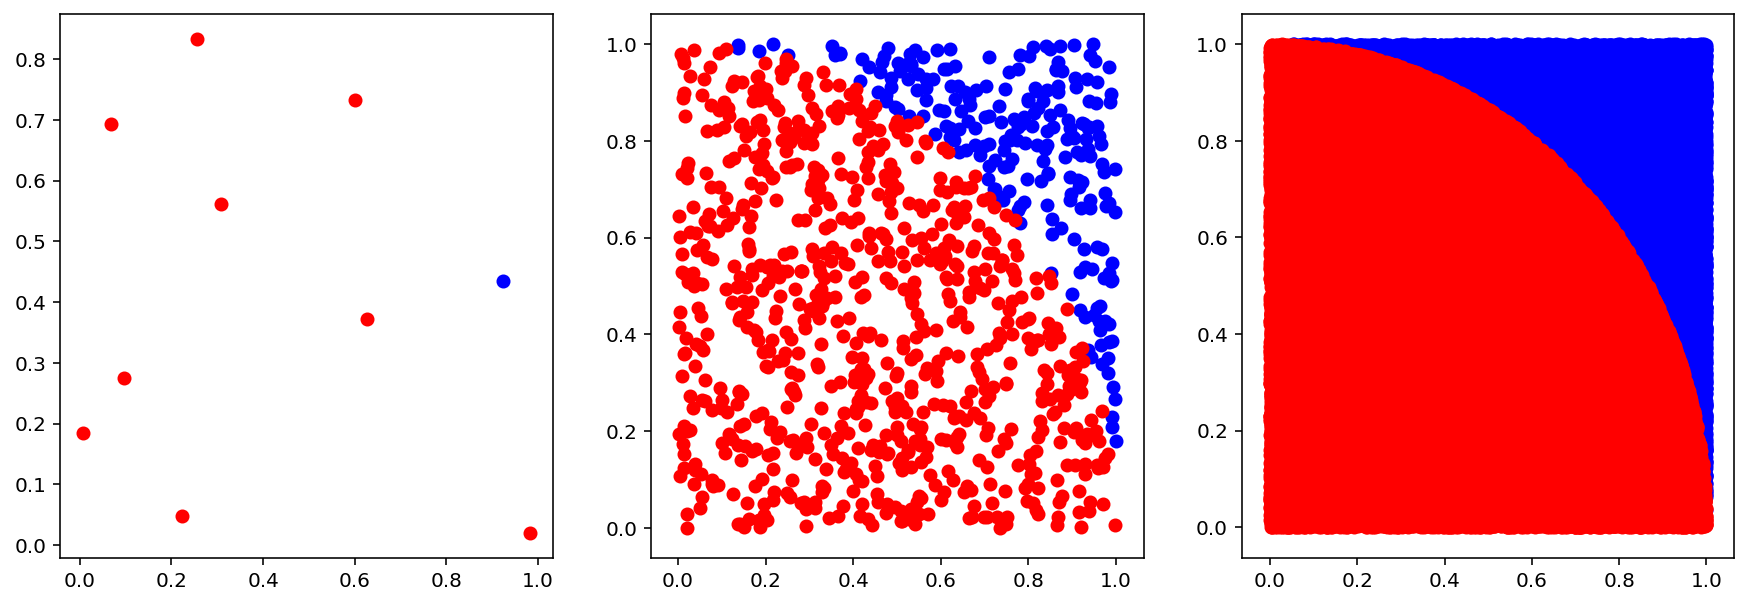

In [7]:
fig = plt.figure(figsize=(15,5))

for i, samp in enumerate([10, 1000, 100000]):
    ax = fig.add_subplot(1, 3, i+1)
    x = st.uniform.rvs(loc=0, scale=1, size=samp)
    y = st.uniform.rvs(loc=0, scale=1, size=samp)
    r = np.sqrt(x**2 + y**2)
    mask = r > 1
    ax.scatter(x[mask], y[mask], color='blue')
    ax.scatter(x[~mask], y[~mask], color='red')
    print(4*len(r[~mask])/len(r))